In [1]:
# Import packages
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import math

In [2]:
# Parameters
yearStart = 2018
yearEnd = 2019
siteLocation = 'London'
excelFile = 'ublox_dlop.xlsx'

In [3]:
# Auxiliar functions
def repeatWeekOfYear( weeksYear ):
    weekYearInWeekDays = np.array([])
    for weekOfYear in weeksYear: 
        weekYearInWeekDays = np.concatenate((weekYearInWeekDays, [weekOfYear]*5), axis=None)
    return(weekYearInWeekDays)

DayOfWeek = pd.Series([1, 2, 3, 4, 5], 
                      index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])

def HH_MM(hour):
    minutes = (hour - int(hour))*60
    return "%02i:%02i" % (hour, minutes) 

In [4]:
# Pre-processing
df = pd.DataFrame()
for yearToRead in range(yearStart, yearEnd+1):
    df_ = pd.read_excel(excelFile, sheet_name=str(yearToRead))
    df_.drop(axis=1, columns="Unnamed: 0" , inplace= True)
    df_.columns = ['Day of Week', 'Entry', 'Exit', 'Hours', 'Status', 'Comment']
    df_.dropna(axis=0, subset = ['Status'], inplace=True)
    index_weekYear = df_['Day of Week'].str.contains('Week')
    weekYear = df_[index_weekYear]['Day of Week'].str.extract('(\d+)').values.flatten().astype(int)
    df_.drop(df_[index_weekYear].index, inplace=True)
    repeatedWeekYear = repeatWeekOfYear(weekYear)
    df_['Week of Year'] = repeatedWeekYear[:len(df_.index)].astype(int)
    df_['Year'] = yearToRead
    df_['Date'] = [dt.datetime.strptime(year+' '+weekYear+' '+DayOfWeek[dayWeek].astype(str), "%Y %W %w")
         for year, weekYear, dayWeek in zip(df_['Year'].values.astype(str), 
                    (df_['Week of Year'].values-1).astype(str),  df_['Day of Week'].values.astype(str))];
    df_ = df_[['Year', 'Week of Year', 'Date', 'Day of Week', 'Entry', 'Exit', 'Hours', 'Status', 'Comment']]
    df_['Entry'].fillna(dt.datetime.strptime('0:0:0', '%H:%M:%S').time(), inplace = True)
    df_['Exit'].fillna(dt.datetime.strptime('0:0:0', '%H:%M:%S').time(), inplace = True)
    df_['Location'] = df_['Status'].str.extract('.*\((.*)\).*',expand=True)
    df_['Location'].fillna(siteLocation, inplace = True)
    df_['Status'] = df_['Status'].str.extract('([a-z-A-Z ]+)', expand=False).str.strip()
    df_.index = df_['Date']
    del df_['Date']
    del df_['Year']
    for date in df_.index:
        df_.loc[date,'Hours'] = (round(((df_['Exit'][date].hour-df_['Entry'][date].hour) + \
                                  (df_['Exit'][date].minute-df_['Entry'][date].minute)/60),2))
    
    df = df.append(df_)

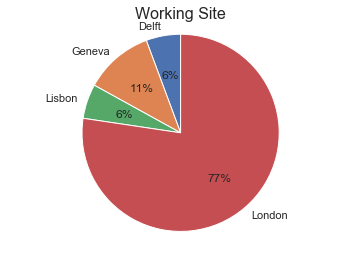

In [5]:
# Working site pie
plt.pie(pd.value_counts(df[df['Comment'].notna()]['Location'].values).sort_index(),
        labels=sorted(df[df['Comment'].notna()]['Location'].unique()),
        startangle=90, autopct='%1.0f%%')
plt.axis('equal')
plt.title('Working Site', fontdict={'size': 16})
plt.show()

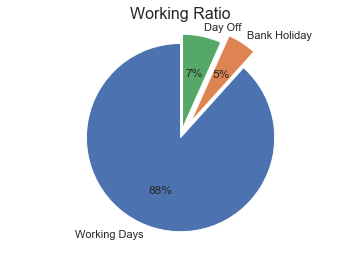

In [6]:
# Working ratio pie
plt.pie([len(df)-len(df[df['Status']=='BANK HOLIDAY'])-len(df[df['Status']=='DAY OFF']), \
           len(df[df['Status']=='BANK HOLIDAY']), len(df[df['Status']=='DAY OFF'])],
         labels = ['Working Days', 'Bank Holiday', 'Day Off'],
         explode = (0, 0.2, 0.1), startangle=90, autopct='%1.0f%%')
plt.axis('equal')
plt.title('Working Ratio', fontdict={'size': 16})
plt.show()

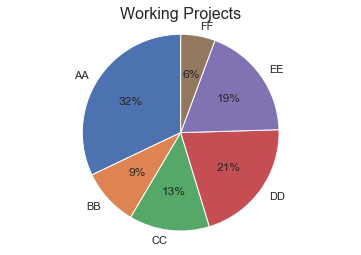

In [7]:
# Working projects pie
plt.pie(pd.value_counts(df[df['Comment'].notna()]['Status'].values).sort_index(),
        labels=sorted(df[df['Comment'].notna()]['Status'].unique()),
        startangle=90, autopct='%1.0f%%')
plt.title('Working Projects', fontdict={'size': 16})
plt.axis('equal')
plt.show()

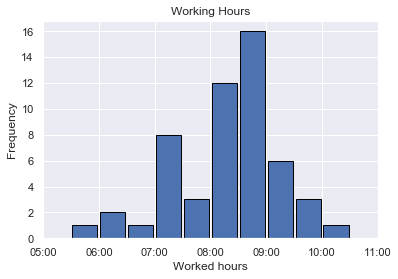

In [21]:
# Working hours histogram
plt.hist(sorted(df[df['Comment'].notna()]['Hours'].values),
         label = sorted(df[df['Comment'].notna()]['Hours'].values),
         bins = np.linspace(5.5, 10.5, 11), edgecolor='black', rwidth=0.9)
plt.xlabel('Worked hours')
plt.ylabel('Frequency')
plt.title('Working Hours')
hRange = np.linspace(5, 11, 7)
plt.xticks(hRange, [HH_MM(hour) for hour in hRange]);
plt.show()

In [9]:
# Statistics regarding Worked hours
print('Minimum worked hours: ' + str(min(df[df['Comment'].notna()]['Hours'].values)))
print('Maximum worked hours: ' + str(max(df[df['Comment'].notna()]['Hours'].values)))
print('Average worked hours: ' + str(round(df[df['Comment'].notna()]['Hours'].mean(), 2)))
print('Median worked hours:  ' + str(round(df[df['Comment'].notna()]['Hours'].median(), 2)))
print('Mode worked hours:  ', df[df['Comment'].notna()]['Hours'].mode().values)

Minimum worked hours: 5.83
Maximum worked hours: 10.25
Average worked hours: 8.2
Median worked hours:  8.42
Mode worked hours:   [8.0 8.5 8.83 9.0]


In [23]:
# Weekly performance
stats = df[df['Hours']>0].groupby([df[df['Hours']>0].index.year, df[df['Hours']>0].index.month, 'Week of Year'])['Hours'] \
        .agg(['size', 'sum', lambda x: round(sum(x)/len(x),2)])
stats.index.names = ['Year', 'Month', 'Week of Year']
stats.columns = ['Worked days', 'Weekly hours', 'Average daily hours']
display(stats)

Worked days  Weekly hours  Average daily hours
Year Month Week of Year                                                
2018 11    47                      5         42.00                 8.40
           48                      5         41.50                 8.30
           49                      5         40.83                 8.17
     12    50                      5         39.58                 7.92
           51                      5         40.33                 8.07
2019 1     1                       3         24.58                 8.19
           2                       5         39.67                 7.93
           3                       5         40.66                 8.13
           4                       5         38.67                 7.73
           5                       4         34.00                 8.50
     2     5                       1          6.08                 6.08
           6                       5         46.50                 9.30

In [11]:
# Auxiliar df columns
entryHours = pd.to_datetime(df['Entry'].astype(str)).dt.hour.values
entryMinutes = pd.to_datetime(df['Entry'].astype(str)).dt.minute.values
Entry = (entryHours + entryMinutes/60).round(2)
df['EntryHM'] = Entry
exitHours = pd.to_datetime(df['Exit'].astype(str)).dt.hour.values
exitMinutes = pd.to_datetime(df['Exit'].astype(str)).dt.minute.values
Exit = (exitHours + exitMinutes/60).round(2)
df['ExitHM'] = Exit

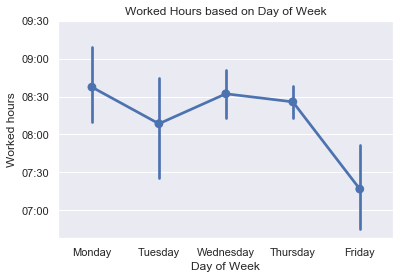

In [12]:
# Worked Hours based on Day of Week
sns.pointplot(x='Day of Week', y='Hours', data=df[df['Comment'].notna()])
plt.title('Worked Hours based on Day of Week');
plt.ylabel('Worked hours')
hRange = np.arange(round(np.percentile(df[df['Comment'].notna()]['Hours'], 10)), \
                   math.ceil(np.percentile(df[df['Comment'].notna()]['Hours'], 90))+1, step=0.5)
plt.yticks(hRange, [HH_MM(hour) for hour in hRange]);

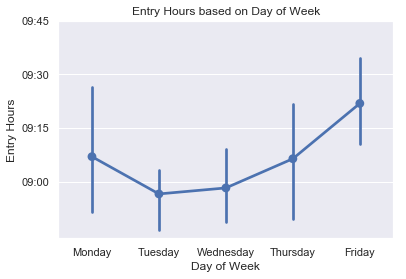

In [13]:
# Entry Hours based on Day of Week
sns.pointplot(x='Day of Week', y='EntryHM', data=df[df['Comment'].notna()])
plt.ylabel('Entry Hours')
plt.title('Entry Hours based on Day of Week');
hRange = np.arange(round(np.percentile(df[df['Comment'].notna()]['EntryHM'], 10)), \
                   math.ceil(np.percentile(df[df['Comment'].notna()]['EntryHM'], 90)), step=0.25)
plt.yticks(hRange, [HH_MM(hour) for hour in hRange]);

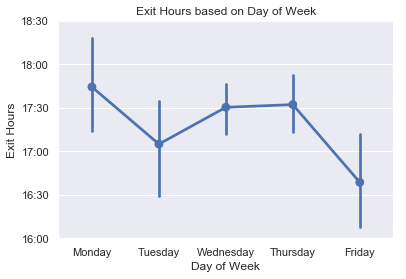

In [14]:
# Exit Hours based on Day of Week
sns.pointplot(x='Day of Week', y='ExitHM', data=df[df['Comment'].notna()], ci=95)
plt.ylabel('Exit Hours')
plt.title('Exit Hours based on Day of Week');
hRange = np.arange(round(np.percentile(df[df['Comment'].notna()]['ExitHM'], 10)), \
                   math.ceil(np.percentile(df[df['Comment'].notna()]['ExitHM'], 90))+1, step=0.5)
plt.yticks(hRange, [HH_MM(hour) for hour in hRange]);

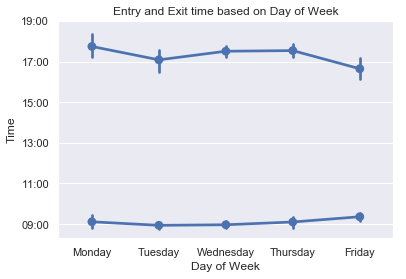

In [15]:
# Entry and Exit times
sns.pointplot(x='Day of Week', y='EntryHM', data=df[df['Comment'].notna()])
sns.pointplot(x='Day of Week', y='ExitHM', data=df[df['Comment'].notna()])
plt.ylabel('Time')
plt.title('Entry and Exit time based on Day of Week');
hRange = np.arange(round(np.percentile(df[df['Comment'].notna()]['EntryHM'], 10)), \
                   math.ceil(np.percentile(df[df['Comment'].notna()]['ExitHM'], 90))+2, step=2)
plt.yticks(hRange, [HH_MM(hour) for hour in hRange]);

In [16]:
df

,Week of Year,Day of Week,Entry,Exit,Hours,Status,Comment,Location,EntryHM,ExitHM
Date,,,,,,,,,,
2018-11-12,47,Monday,10:00:00,18:30:00,8.5,AA,Some comment,London,10.00,18.50
2018-11-13,47,Tuesday,09:00:00,17:30:00,8.5,AA,Some comment,London,9.00,17.50
2018-11-14,47,Wednesday,08:45:00,17:45:00,9,AA,Some comment,London,8.75,17.75
2018-11-15,47,Thursday,08:45:00,16:45:00,8,AA,Some comment,London,8.75,16.75
2018-11-16,47,Friday,09:15:00,17:15:00,8,AA,Some comment,London,9.25,17.25
2018-11-19,48,Monday,08:50:00,17:50:00,9,AA,Some comment,London,8.83,17.83
2018-11-20,48,Tuesday,08:50:00,17:20:00,8.5,BB,Some comment,London,8.83,17.33
2018-11-21,48,Wednesday,09:00:00,18:00:00,9,CC,Some comment,Lisbon,9.00,18.00
2018-11-22,48,Thursday,09:00:00,17:00:00,8,BB,Some comment,Lisbon,9.00,17.00
